# Когортный анализ вовлеченности пользователей

Компании должны иметь возможность измерять вовлеченность и удержание пользователей для количественной оценки разнообразной информации: 
- как она меняется с течением времени; 
- насколько она чувствительна к внешним событиям и сезонности; 
- как различные группы пользователей взаимодействуют c продуктом. 

Продукт часто может быть приложением, с которым пользователи взаимодействуют для получения некоторых услуг. Следовательно, engagement можно просто определить как активность пользователя в приложении.

Задача: исследовать вовлеченность пользователей с помощью когортного анализа.

> Когорта — это группа людей, которые имеют общие характеристики в течение определенного периода времени»

Чтобы упростить задачу, давайте предположим, что эта общая характеристика — это неделя, когда пользователь впервые открывает приложение. Это устанавливает статус этого пользователя как активного. Если этот пользователь не откроет приложение на следующей неделе, его статус будет — неактивный. Основываясь на этом, можно придумать следующие определения статуса для активных и неактивных пользователей, которые помогут нам отслеживать различные когорты с течением времени.

Следуя этой логике, мы можем взять за основу, что в любую неделю

- Общее количество удержанных, возвращенных и ушедших пользователей равно совокупной сумме всех новых пользователей с предыдущих недель до этой недели.
- Коэфициент удержания (сумма удержанных пользователей) / (сумма удержанных пользователей + сумма ушедших пользователей)

In [ ]:
!python -c 'print(__import__("sys").version[:3])'

3.7


Требуется обновить SQLite, чтобы можно было использовать оконные функции.

In [ ]:
!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz
!tar xzf sqlite.tar.gz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.$(python -V | cut -d"." -f2)/pysqlite3/_sqlite3.cpython-3$(python -V | cut -d"." -f2)m-x86_64-linux-gnu.so \
    /usr/lib/python3.$(python -V | cut -d"." -f2)/lib-dynload/_sqlite3.cpython-3$(python -V | cut -d"." -f2)m-x86_64-linux-gnu.so

--2022-10-30 15:02:19--  https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release
Resolving www.sqlite.org (www.sqlite.org)... 45.33.6.223, 2600:3c00::f03c:91ff:fe96:b959
Connecting to www.sqlite.org (www.sqlite.org)|45.33.6.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11805377 (11M) [application/x-compressed]
Saving to: ‘sqlite.tar.gz’

sqlite.tar.gz       100%[===================>]  11.26M  32.9MB/s    in 0.3s    

2022-10-30 15:02:20 (32.9 MB/s) - ‘sqlite.tar.gz’ saved [11805377/11805377]

/content/sqlite
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
chec

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import string
from itertools import product
from sqlalchemy import create_engine
import plotly.offline as pyo
from IPython.display import HTML, display

pyo.init_notebook_mode()

In [ ]:
sqlite3.sqlite_version

'3.39.4'

## Генерация искуственных данных
Так как у нас нет исходных данных, создадим собственную таблицу фииктивной активности пользователей и отправим ее в базу данных SQLite, чтобы можно было использовать SQL-запросы. Наша таблица будет иметь 3 основных столбца: 
- `user_id`;
- `activity_day`;
- `app_opens`.

In [ ]:
AB = (list(string.ascii_uppercase)
      + list(map(''.join, product(string.ascii_uppercase, repeat=2))))

In [ ]:
userid_list = [f'{letter}{i:02d}' for letter in AB for i in range(1,21)]

In [ ]:
np.random.seed(10)

app_opens = np.random.poisson(lam=10, size=2*len(userid_list))
user_ids = np.concatenate((userid_list, userid_list))
app_activations = (np.datetime64('2022-01-06')
                   + np.random.choice(np.arange(0, 180), len(userid_list)))
activity_days = np.concatenate((app_activations, app_activations + 7))
random_user_ids = userid_list.copy() #[x for x in userid_list]

for days_passed in range(14, 106, 7):
    user_id_sample = int(np.floor(len(random_user_ids) * 0.98))
    if user_id_sample:
        random_user_ids = [random_user_ids[x] for x in 
                           np.random.choice(range(len(random_user_ids)),
                                            size=user_id_sample,
                                            replace=False)]
    user_ids = np.concatenate((user_ids, random_user_ids))
    app_opens = np.concatenate((app_opens,
                                np.random.choice(range(3, 7), 
                                                 size=user_id_sample, 
                                                 p=[0.2, 0.3, 0.3, 0.2])))
        
    activity_days = np.concatenate(
        (activity_days, [app_activations[userid_list.index(x)] + days_passed
                                                      for x in random_user_ids])
        )
    
df_user_activity = pd.DataFrame(zip(user_ids, activity_days, app_opens), 
                                columns=['user_id', 'activity_day', 'app_opens'])
df_user_activity = df_user_activity.groupby(['user_id'], group_keys=False) \
    .apply(lambda df: df.sample(len(df)-2)).sort_index().reset_index(drop=True)
df_user_activity['count'] = df_user_activity.groupby(['user_id'])['activity_day'] \
    .transform(len)
df_user_activity.loc[df_user_activity['count'] == 1, 'app_opens'] = \
     np.minimum(5, df_user_activity['app_opens'])
df_user_activity = df_user_activity.drop(['count'], axis=1)

df_user_activity

user_id activity_day  app_opens
0          A02   2022-06-20         11
1          A03   2022-03-26         10
2          A04   2022-06-26          7
3          A05   2022-06-14          6
4          A06   2022-06-01         13
...        ...          ...        ...
169440    TX01   2022-08-15          3
169441    QK06   2022-05-10          5
169442    EQ17   2022-07-27          3
169443    VJ13   2022-06-29          6
169444    PT05   2022-07-19          5

[169445 rows x 3 columns]

Отправляем получившийся датафрейм в БД SQLite.

In [ ]:
engine = create_engine('sqlite:///' + 'engagement.db',
                       connect_args={'check_same_thread': False}).connect()
df_user_activity.to_sql(name='user_activity',
                        index=False,
                        con=engine,
                        if_exists='replace')

def select(query):
  return pd.read_sql(query, con=engine)

Следующий запрос для получения представления для последующего когортного анализа. Для периода (42 недели) создается таблица, в которой хранятся `user_id`, `week` и `weekly_flags` (например, новые, сохраненные, восстановленные и измененные). В этой таблице 13720 уникальных идентификаторов пользователей * 42 недели = 576240 строк.

Первой создается таблица `date_table` еженедельных периодов, чтобы объединить их с `user_activity_daily`, чтобы указать недостающие недели для каждого пользователя. Основная цель — получить табличное представление, в котором для каждого идентификатора пользователя у нас есть 42-недельные периоды, и их общее еженедельное количество открытий приложения. Каждый день активности в конвертируется в формат «Год-Неделя» для последующей группировки и вычисления lifetime, открытий на предыдущую неделю и предыдущий lifetime, чтобы посчитать новых, удержанных, активных, вовлеченных пользователей и установить соответствующие флаги.

In [ ]:
query = '''
WITH date_table AS (
  WITH recursive date_in_range(day) AS (
    VALUES('2021-12-30')
    UNION ALL
    SELECT date(day, '+7 day')
    FROM date_in_range
    WHERE date(day, '+7 day') < '2022-10-19'
  )
  SELECT
    STRFTIME('%Y-%W', day) AS year_week,
    ROW_NUMBER() OVER(ORDER BY day) AS yw_id
  FROM date_in_range
)
SELECT
  user_id
  , year_week
  , weekly_app_opens
  , lifetime_app_opens
  , prev_week_app_opens
  , prev_lifetime_app_opens
  , CASE
      WHEN
        weekly_app_opens = lifetime_app_opens
          AND weekly_app_opens > 0
      THEN 1
      ELSE 0
    END AS new_flag
  , CASE
      WHEN
        weekly_app_opens > 0
          AND prev_lifetime_app_opens > 0
          AND prev_week_app_opens != 0
      THEN 1
      ELSE 0
    END AS retained_flag
  , CASE 
      WHEN
        weekly_app_opens > 0
      THEN 1
      ELSE 0
    END AS active_flag
  , CASE
      WHEN
        prev_lifetime_app_opens > 0
          AND weekly_app_opens = 0
      THEN 1
      ELSE 0
      END AS churned_flag
  , CASE
      WHEN
        weekly_app_opens > 0
          AND prev_week_app_opens = 0
          AND prev_lifetime_app_opens > 0
      THEN 1
      ELSE 0
    END AS regained_flag
  FROM (
      SELECT
        joined_grouped_view.user_id
        , joined_grouped_view.year_week
        , joined_grouped_view.weekly_app_opens
        , SUM(weekly_app_opens) OVER(
                                  PARTITION BY user_id ORDER BY year_week
                                ) AS lifetime_app_opens
        , LAG(weekly_app_opens) OVER(
                                  PARTITION BY user_id ORDER BY year_week
                                ) AS prev_week_app_opens
        , SUM(weekly_app_opens) OVER(
                                  PARTITION BY user_id ORDER BY year_week
                                ) - weekly_app_opens AS prev_lifetime_app_opens
      FROM (
          SELECT
            ROW_NUMBER() OVER(PARTITION BY grouped_ua.user_id) AS user_row_no
            , grouped_ua.user_id
            , dt.year_week
            , SUM(CASE
                    WHEN grouped_ua.year_week_left = dt.year_week
                    THEN grouped_ua.weekly_app_opens
                    ELSE 0
                  END
              ) AS weekly_app_opens
          FROM (
              SELECT
                ua.user_id
                , STRFTIME('%Y-%W', activity_day) AS year_week_left
                , SUM(app_opens) AS weekly_app_opens
              FROM user_activity AS ua
              GROUP BY ua.user_id, year_week_left
          ) AS grouped_ua
          JOIN date_table dt
          GROUP BY grouped_ua.user_id, dt.year_week
      ) AS joined_grouped_view
) AS table_for_flags;
'''

Тоже самое, только с помощью pandas.

In [ ]:
periods = 42
date_table = pd.DataFrame(
    [f'{dt:%Y-%W}' for dt in
        pd.date_range('2021-12-30', freq='7D', periods=periods)],
    columns=['year_week']
    ).assign(yw_id=lambda df: range(1, periods+1))

In [ ]:
def flags(df):
    return df.assign(
        active_flag=df.eval('1 * (weekly_app_opens > 0)'),
        new_flag=df.eval(
            '1 * (weekly_app_opens == lifetime_app_opens & weekly_app_opens > 0)'
            ),
        retained_flag=df.eval(
            '1 * (prev_lifetime_app_opens > 0 & prev_week_app_opens != 0' \
            '& weekly_app_opens > 0)'
            ).astype(int),
        churned_flag=df.eval(
            '1 * (prev_lifetime_app_opens > 0 & weekly_app_opens == 0)'
            ),
        regained_flag=df.eval(
            '1 * (weekly_app_opens > 0 & prev_week_app_opens == 0' \
            '& prev_lifetime_app_opens > 0)'
            ).astype(int)
        )

In [ ]:
df_weekly_activity = df_user_activity[['user_id', 'activity_day', 'app_opens']] \
    .assign(
        year_week=df_user_activity['activity_day'].dt.strftime('%Y-%W')
        ).groupby(['user_id', 'year_week'], as_index=False) \
           .agg({'app_opens': sum}) \
    .assign(key=1) \
    .merge(date_table.assign(key=1),
           on='key',
           how='outer',
           suffixes=('_left', '')) \
    .assign(weekly_app_opens=lambda df:
            df.eval('app_opens * (year_week_left == year_week)')) \
    .groupby(['user_id', 'year_week'], as_index=False) \
    .agg({'weekly_app_opens': sum}) \
    .assign(
        # user_row_no=lambda df: df.groupby('user_id').cumcount().add(1),
        lifetime_app_opens=lambda df: df.groupby('user_id')['weekly_app_opens'] \
            .transform('cumsum'),
        prev_week_app_opens=lambda df: df.groupby('user_id')['weekly_app_opens'] \
            .transform('shift'),
        prev_lifetime_app_opens=lambda df: df['lifetime_app_opens'] - \
            df['weekly_app_opens']
            ).pipe(flags)

In [ ]:
df_weekly_activity_sql = select(query)
df_weekly_activity.equals(df_weekly_activity_sql[df_weekly_activity.columns])

True

В таблице ниже показано общее количество новых, удержанных, активных, восстановленных и ушедших пользователей за неделю.

In [ ]:
df_overall_summary = df_weekly_activity \
    .groupby(['year_week'])[
        ['new_flag', 
        'retained_flag', 
        'active_flag', 
        'churned_flag', 
        'regained_flag']
    ].sum().reset_index()

df_overall_summary.head()

year_week  new_flag  retained_flag  active_flag  churned_flag  regained_flag
0   2021-52         0              0            0             0              0
1   2022-01       238              0          238             0              0
2   2022-02       463            202          665            36              0
3   2022-03       522            547         1099           124             30
4   2022-04       508            926         1534           197            100

Например, если мы посмотрим на первые 3 строки приведенного выше датафрейма, мы увидим, что в первую неделю 2022 года 238 пользователей впервые открыли приложение. На следующей неделе из этих 238 72 не открывали приложение и 202 все еще были активны в дополнение к 463 вновь присоединившимся.

Теперь, когда у нас есть представление о еженедельной активности пользователей, давайте проанализируем и визуализируем когорты.

Рассмотрим пути активности всех пользователей, сгруппировав пользователей за одну и ту же неделю вместе с целью — определить, наблюдается ли падение активности у всех после N-й недели. Среднее количество активных пользователей из тех, у кого есть `new_flag` на неделе X, будет исследоваться в течение недели X (активность 100%), недели X+1, X+2, X+3, X+4 и т. д.

In [ ]:
df_weekly_activity['new_flag_cumsum'] = df_weekly_activity.groupby(['user_id']) \
    ['new_flag'].cumsum()
df_cohort_prep = df_weekly_activity[df_weekly_activity['new_flag_cumsum'] > 0] \
    .reset_index(drop=True)
df_cohort = df_cohort_prep.merge(
    df_cohort_prep[df_cohort_prep['new_flag'] == 1][['user_id', 'year_week']] \
        .rename(columns={'year_week': 'joined_on'}),
    how='left',
    on=['user_id']
    )
df_cohort['Nth_Week'] = (df_cohort['year_week'].str[:4].astype(int) * 52 + 
                         df_cohort['joined_on'].str[:4].astype(int) * 52 * -1 + 
                         df_cohort['year_week'].str[-2:].astype(int) + 
                         df_cohort['joined_on'].str[-2:].astype(int) * -1 
                         + 1)

Первая неделя — это всегда 100%, потому что именно в этот период пользователь считается новым.

In [ ]:
df_heatmap = pd.pivot_table(
    df_cohort[df_cohort['Nth_Week'] < 20],
    index=['joined_on'], 
    columns=['Nth_Week'], 
    values=['active_flag'], 
    aggfunc=np.mean
)

In [ ]:
df_heatmap

active_flag                                                    \
Nth_Week           1         2         3         4         5         6    
joined_on                                                                 
2022-01           1.0  0.848739  0.819328  0.852941  0.827731  0.857143   
2022-02           1.0  0.825054  0.842333  0.848812  0.831533  0.838013   
2022-03           1.0  0.829502  0.854406  0.812261  0.831418  0.802682   
2022-04           1.0  0.816929  0.840551  0.836614  0.799213  0.783465   
2022-05           1.0  0.809249  0.801541  0.824663  0.820809  0.793834   
2022-06           1.0  0.836397  0.808824  0.830882  0.794118  0.821691   
2022-07           1.0  0.831094  0.834933  0.821497  0.840691  0.811900   
2022-08           1.0  0.842520  0.838583  0.791339  0.785433  0.783465   
2022-09           1.0  0.830508  0.806026  0.798493  0.817326  0.794727   
2022-10           1.0  0.826816  0.793296  0.824953  0.841713  0.824953   
2022-11           1.0  0.847222  0.845486  0.829861  0.812500  0.805556   
2022-12           1.0  0.838182  0.834545  0.810909  0.836364  0.810909   
2022-13           1.0  0.854015  0.813869  0.821168  0.826642  0.781022   
2022-14           1.0  0.828780  0.799636  0.819672  0.799636  0.761384   
2022-15           1.0  0.833333  0.829457  0.844961  0.821705  0.815891   
2022-16           1.0  0.829868  0.822306  0.844991  0.824197  0.816635   
2022-17           1.0  0.798131  0.829907  0.796262  0.814953  0.785047   
2022-18           1.0  0.841418  0.828358  0.830224  0.830224  0.819030   
2022-19           1.0  0.854015  0.837591  0.804745  0.815693  0.804745   
2022-20           1.0  0.814208  0.828780  0.801457  0.795993  0.772313   
2022-21           1.0  0.813433  0.802239  0.807836  0.811567  0.779851   
2022-22           1.0  0.823748  0.794063  0.847866  0.821892  0.814471   
2022-23           1.0  0.838182  0.800000  0.807273  0.834545  0.821818   
2022-24           1.0  0.809074  0.812854  0.805293  0.773157  0.799622   
2022-25           1.0  0.828970  0.821990  0.820244  0.815009  0.811518   
2022-26           1.0  0.854962  0.845420  0.835878  0.814885  0.812977   
2022-27           1.0  0.798742  0.761006  0.811321  0.723270  0.672956   
2022-28           1.0  0.894737  0.789474  0.736842  0.736842  0.631579   
2022-29           1.0  0.666667  0.666667  0.333333  0.333333  0.333333   

                                                                       \
Nth_Week         7         8         9         10        11        12   
joined_on                                                               
2022-01    0.823529  0.760504  0.798319  0.764706  0.781513  0.773109   
2022-02    0.818575  0.799136  0.814255  0.777538  0.777538  0.771058   
2022-03    0.842912  0.795019  0.787356  0.773946  0.770115  0.760536   
2022-04    0.793307  0.781496  0.759843  0.744094  0.708661  0.716535   
2022-05    0.780347  0.759152  0.747592  0.776493  0.739884  0.712909   
2022-06    0.803309  0.775735  0.772059  0.738971  0.716912  0.731618   
2022-07    0.783109  0.790787  0.765835  0.754319  0.735125  0.738964   
2022-08    0.779528  0.777559  0.751969  0.748031  0.736220  0.720472   
2022-09    0.760829  0.747646  0.740113  0.728814  0.713748  0.696798   
2022-10    0.783985  0.778399  0.772812  0.750466  0.737430  0.748603   
2022-11    0.779514  0.791667  0.732639  0.748264  0.718750  0.730903   
2022-12    0.781818  0.752727  0.760000  0.743636  0.745455  0.721818   
2022-13    0.760949  0.791971  0.770073  0.742701  0.720803  0.709854   
2022-14    0.794171  0.777778  0.743169  0.763206  0.735883  0.712204   
2022-15    0.798450  0.767442  0.771318  0.744186  0.730620  0.703488   
2022-16    0.795841  0.782609  0.773157  0.761815  0.744802  0.737240   
2022-17    0.803738  0.768224  0.757009  0.738318  0.768224  0.708411   
2022-18    0.779851  0.794776  0.779851  0.757463  0.742537  0.731343   
2022-19    0.777372  0.779197  0.790146  0.750000  0.744526  0.737226   
202

In [25]:
import plotly.graph_objects as go

def heatmap(df, params, show=None):
    fig = go.Figure(
        data=go.Heatmap(
            z=df,
            x=df.columns.droplevel(0) if isinstance(
                df.columns, pd.core.indexes.multi.MultiIndex
                ) else df.columns,
            y=df.index,
            zmin=df.min(axis=1).min(), 
            zmax=df.max(axis=1).max(),
            text=df.to_numpy(),
            texttemplate='%{text:.1f}',
            textfont={'size': 9},
            colorscale='balance', # pubu
            showscale=True
            )
        )
    fig.update_yaxes(autorange='reversed',
                    type='category',
                    categoryorder='array',
                    automargin=True)
    fig.update_xaxes(automargin=True,
                    side='bottom',
                    type='category',
                    categoryorder='array')
    fig.update_layout(**params,
                      height=750,
                      width=1200,
                      template='plotly_white',
                      margin_pad=10)
    fig.show(show)

In [24]:
# pip install -U kaleido

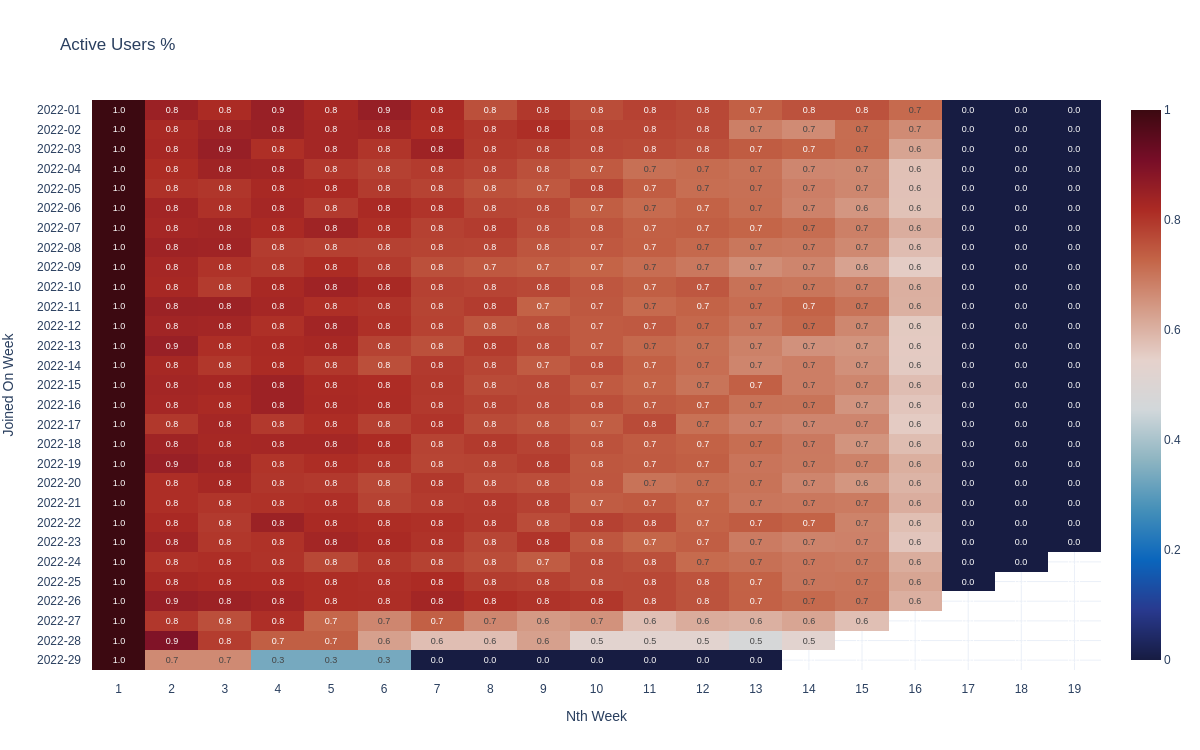

In [26]:
params = dict(title='Active Users %',
              xaxis_title='Nth Week',
              yaxis_title='Joined On Week')

heatmap(df_heatmap, params, 'png')

Видно, что активность пользователей снижается до 80–85% на 2-й неделе и продолжает снижаться, и у многих когорт активность падает до 0% после 16-й недели.

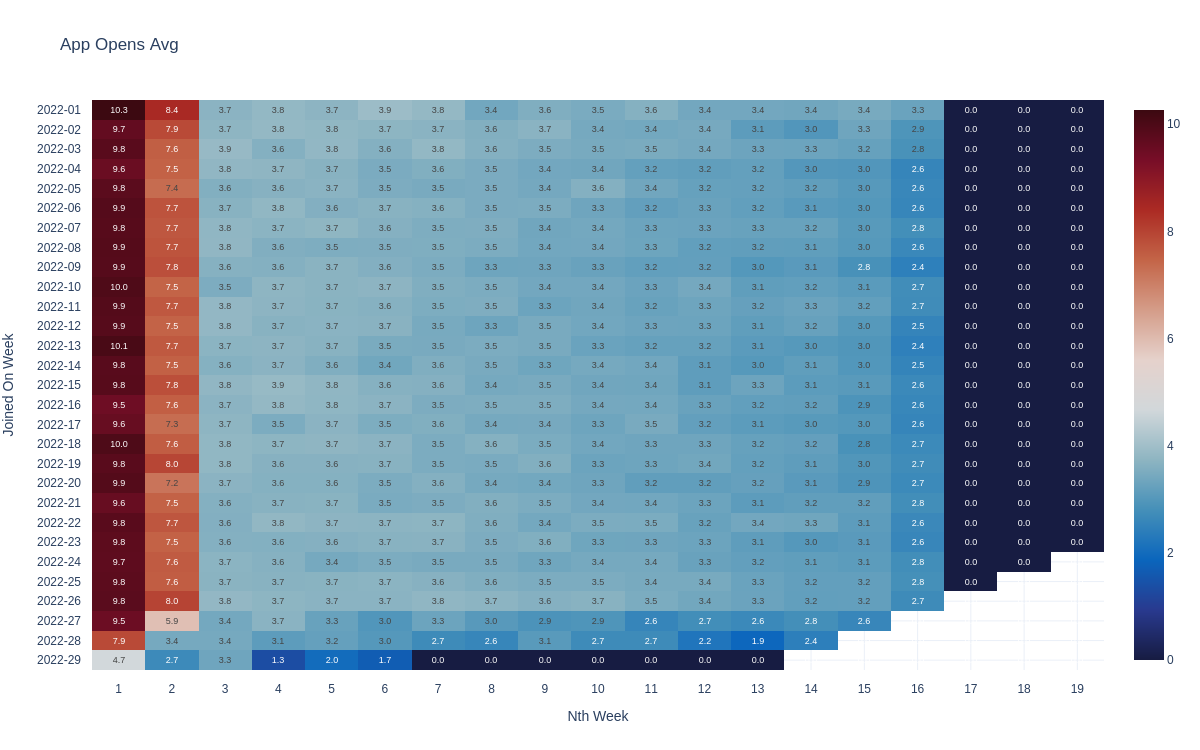

In [27]:
df_heatmap = pd.pivot_table(
    df_cohort[df_cohort['Nth_Week'] < 20], 
    index=['joined_on'], 
    columns=['Nth_Week'], 
    values=['weekly_app_opens'], 
    aggfunc='mean'
    )

params = dict(title='App Opens Avg',
              xaxis_title='Nth Week',
              yaxis_title='Joined On Week')

heatmap(df_heatmap, params, 'png')

В среднем пользователи открывают приложение 9–10 раз в первую неделю, а затем 7–8 раз во вторую неделю. Прежде чем полностью перестать пользоваться приложением, они открывают его 2–2,5 раза в неделю.

In [28]:
df_churned_forever_index = df_cohort[
    df_cohort['active_flag'].eq(1).sort_index(ascending=False).mul(1) \
        .groupby(level=0).cumsum().eq(0).sort_index(axis=0)
    ].groupby('user_id', sort=False)['Nth_Week'].idxmin() \
        .reset_index().rename(columns={'Nth_Week': 'index_value'})

Поиск индексов строк, в которых пользователь забросил приложение навсегда.

In [29]:
df_cohort = df_cohort.merge(df_churned_forever_index, how='left', on=['user_id'])
df_cohort_churned_forever = df_cohort[
    df_cohort.index <= df_cohort['index_value']
    ].reset_index(drop=True)

Для всех ушедших пользователей посмотрим детально — сколько ушло только через 2 недели, 3 недели, N недель, и каковы средние показатели `weekly_app_opens`.

In [30]:
df_users_churning_week = df_cohort_churned_forever.groupby('user_id') \
    ['Nth_Week'].max().reset_index()

leaving_users = []
for num_week in range(2,15):
    list_of_users_leaving_n_week = df_users_churning_week[
          df_users_churning_week['Nth_Week'] == num_week
          ]['user_id'].tolist()
    leaving_users.append(df_cohort_churned_forever[
        df_cohort_churned_forever['user_id'].isin(list_of_users_leaving_n_week)
        ].groupby(['Nth_Week'])['weekly_app_opens'].mean().reset_index()
            .rename(columns={
                'weekly_app_opens': f'{len(list_of_users_leaving_n_week)} ' \
                                    f'Users Leaving in Week {num_week}'
                }).set_index(['Nth_Week']))
    
df_churned_users_weekly_app_opens = pd.concat(leaving_users, sort=False, axis=1)
df_churned_users_weekly_app_opens.reset_index()

Nth_Week  2334 Users Leaving in Week 2  1974 Users Leaving in Week 3  \
0          1                      9.290488                      9.912361   
1          2                      0.000000                      9.378419   
2          3                           NaN                      0.000000   
3          4                           NaN                           NaN   
4          5                           NaN                           NaN   
5          6                           NaN                           NaN   
6          7                           NaN                           NaN   
7          8                           NaN                           NaN   
8          9                           NaN                           NaN   
9         10                           NaN                           NaN   
10        11                           NaN                           NaN   
11        12                           NaN                           NaN   
12        13                           NaN                           NaN   
13        14                           NaN                           NaN   

    1565 Users Leaving in Week 4  1348 Users Leaving in Week 5  \
0                       9.954633                      9.821217   
1                       9.374441                      9.451780   
2                       4.499042                      4.514837   
3                       0.000000                      4.543769   
4                            NaN                      0.000000   
5                            NaN                           NaN   
6                            NaN                           NaN   
7                            NaN                           NaN   
8                            NaN                           NaN   
9                            NaN                           NaN   
10                           NaN                           NaN   
11                           NaN                           NaN   
12                           NaN                           NaN   
13                           NaN                           NaN   

    1195 Users Leaving in Week 6  1031 Users Leaving in Week 7  \
0                       9.999163                     10.033948   
1                       9.292050                      9.406402   
2                       4.567364                      4.518914   
3                       4.461088                      4.500485   
4                       4.475314                      4.475267   
5                       0.000000                      4.475267   
6                            NaN                      0.000000   
7                            NaN                           NaN   
8                            NaN                           NaN   
9                            NaN                           NaN   
10                           NaN                           NaN   
11                           NaN                           NaN   
12                           NaN                           NaN   
13                           NaN                           NaN   

    914 Users Leaving in Week 8  776 Users Leaving in Week 9  \
0                      9.961707                    10.056701   
1                      9.119256                     9.194588   
2                      4.479212                     4.430412   
3                      4.501094                     4.400773   
4                      4.538293                     4.461340   
5                      4.457330                     4.425258   
6                      4.522976                     4.523196   
7                      0.000000                     4.461340   
8                           NaN                     0.000000   
9                           NaN                          NaN   
10                          NaN                          NaN   
11                          NaN                          NaN   
12                          NaN                  

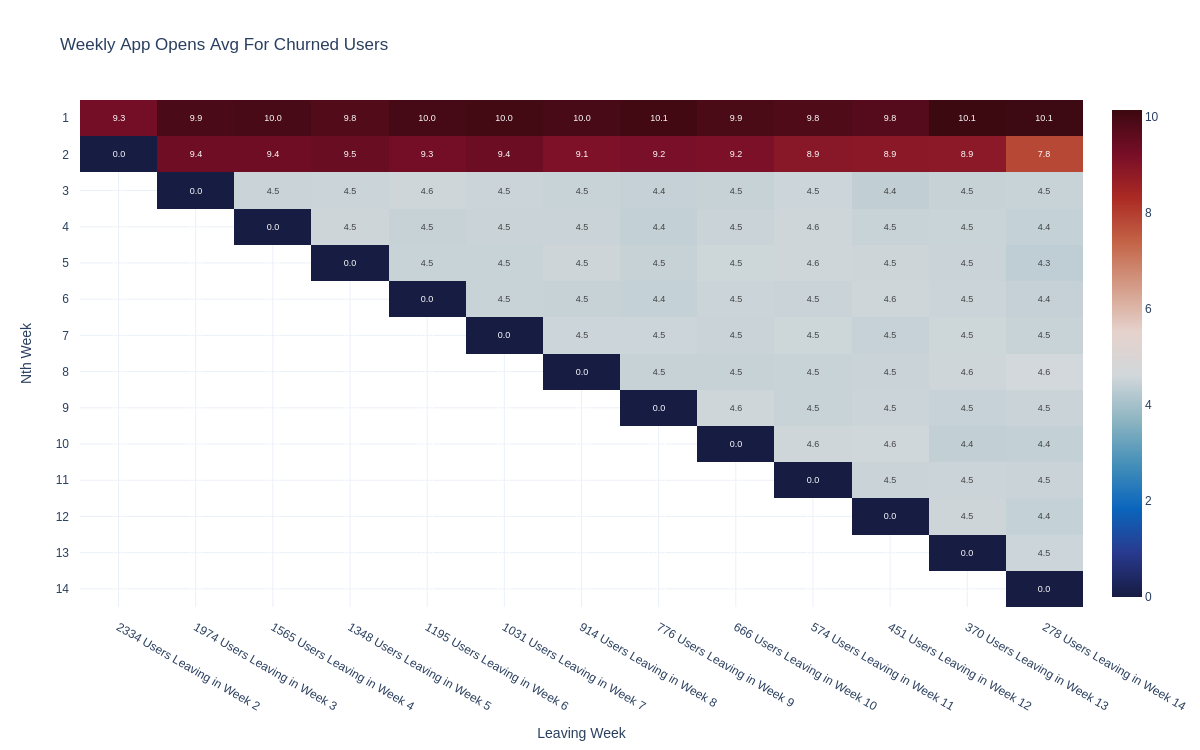

In [31]:
params = dict(title='Weekly App Opens Avg For Churned Users',
              xaxis_title='Leaving Week',
              yaxis_title='Nth Week')

heatmap(df_churned_users_weekly_app_opens, params, 'png')

Пользователи, которые уходят на 2-й неделе и никогда не возвращаются, — это те, кто открывает приложение в среднем 4,5 раза в первую неделю.